#MACHINE TRANSLATION - ASSIGNMENT4
### BY: Muhammad Raamish Alam (20k-1326) and Ashar Ansari (20k-1409)

### SUBMITTED TO: Sir Raza Abbas
### SUBJECT: NLP (DS-5007)






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###NOTE: (LINK TO THE FILES REQUIRED TO RUN THIS NOTEBOOK below)
### https://drive.google.com/drive/folders/167z1uolenvlvA7OESxfKcsUNC-w480WY?usp=share_link

# FRENCH TO ENGLISH (DEFAULT CODE TAKEN FROM GITHUB):

Neural Translation Model in PyTorch
by Mac Brennan
Translation Model Summary

This project will be broken up into several parts as follows:

Part 1: Preparing the words

Inspecting the Dataset
Using Word Embeddings
Organizing the Data
Part 2: Building the Model

Bi-Directional Encoder
Building Attention
Decoder with Attention
Part 3: Training the Model

Training Function
Training Loop
Part 4: Evaluation

This project closely follows the PyTorch Sequence to Sequence tutorial, while attempting to go more in depth with both the model implementation and the explanation. Thanks to Sean Robertson and PyTorch for providing such great tutorials.

If you are working through this notebook, it is strongly recommended that Jupyter Notebook Extensions is installed so you can turn on collapsable headings. It makes the notebook much easier to navigate.

In [ ]:
# Before we get started we will load all the packages we will need

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os.path
import time
import math
import random
import matplotlib.pyplot as plt
import string

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

**Inspecting the Dataset**
The dataset that will be used is a text file of english sentences and the corresponding french sentences.

Each sentence is on a new line. The sentences will be split into a list.

**Load the data**
The data will be stored in two lists where each item is a sentence. The lists are:

english_sentences

*   List item
*   List item


french_sentences
Download the first dataset from the projects' github repo. Place it in the same folder as the notebook or create a data folder in the notebook's folder.

In [ ]:
with open('/content/drive/MyDrive/machinetranslation/small_vocab_en', "r") as f:
    data1 = f.read()
with open('/content/drive/MyDrive/machinetranslation/small_vocab_fr', "r") as f:
    data2 = f.read()
    
# The data is just in a text file with each sentence on its own line
english_sentences = data1.split('\n')
french_sentences = data2.split('\n')


In [ ]:
print('Number of English sentences:', len(english_sentences), 
      '\nNumber of French sentences:', len(french_sentences),'\n')
print('Example/Target pair:\n')
print('  '+english_sentences[2])
print('  '+french_sentences[2])

Number of English sentences: 137861 
Number of French sentences: 137861 

Example/Target pair:

  california is usually quiet during march , and it is usually hot in june .
  california est généralement calme en mars , et il est généralement chaud en juin .


Number of English sentences: 137861 
Number of French sentences: 137861 

Example/Target pair:

  california is usually quiet during march , and it is usually hot in june .
  california est généralement calme en mars , et il est généralement chaud en juin .

**Vocabulary**
Let's take a closer look at the dataset.

In [ ]:
english_sentences[2].split()

['california',
 'is',
 'usually',
 'quiet',
 'during',
 'march',
 ',',
 'and',
 'it',
 'is',
 'usually',
 'hot',
 'in',
 'june',
 '.']

In [ ]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length) 

The longest english sentence in our dataset is: 17


In [ ]:
max_fr_length = 0
for sentence in french_sentences:
    length = len(sentence.split())
    max_fr_length = max(max_fr_length, length)
print("The longest french sentence in our dataset is:", max_fr_length)

The longest french sentence in our dataset is: 23


In [ ]:
max_seq_length = max(max_fr_length, max_en_length) + 1
seq_length = max_seq_length

In [ ]:
en_word_count = {}
fr_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in french_sentences:
    for word in sentence.split():
        if word in fr_word_count:
            fr_word_count[word] +=1
        else:
            fr_word_count[word] = 1

In [ ]:
# Add end of sentence token to word count dict
en_word_count[''] = len(english_sentences)
fr_word_count[''] = len(english_sentences)

In [ ]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique French words:', len(fr_word_count))

Number of unique English words: 228
Number of unique French words: 356


In [ ]:
def get_value(items_tuple):
    return items_tuple[1]

# Sort the word counts to see what words or most/least common
sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [ ]:
sorted_en_words[:10]

[('is', 205858),
 (',', 140897),
 ('', 137861),
 ('.', 129039),
 ('in', 75525),
 ('it', 75137),
 ('during', 74933),
 ('the', 67628),
 ('but', 63987),
 ('and', 59850)]

In [ ]:
sorted_fr_words = sorted(fr_word_count.items(), key=get_value, reverse=True)

In [ ]:
sorted_fr_words[:10]

[('est', 196809),
 ('', 137861),
 ('.', 135619),
 (',', 123135),
 ('en', 105768),
 ('il', 84079),
 ('les', 65255),
 ('mais', 63987),
 ('et', 59851),
 ('la', 49861)]

So the dataset is pretty small, we may want to get a bigger data set, but we'll see how this one does.

**Alternate Dataset**
Skip this section for now. You can come back and try training on this second dataset later. It is more diverse so it takes longer to train.

Download the French-English dataset from here, Although you could train the model on any of the other language pairs. However, you would need different word embeddings or they would need to be trained from scratch.

In [ ]:
with open('/content/drive/MyDrive/machinetranslation/fra.txt', "r") as f:
    data1 = f.read()

In [ ]:
pairs = data1.split('\n')
english_sentences = []
french_sentences = []
for i, pair in enumerate(pairs):
    pair_split = pair.split('\t')
    if len(pair_split)!= 2:
        continue
    english = pair_split[0].lower()
    french = pair_split[1].lower()
    
    # Remove punctuation and limit sentence length
    max_sent_length = 10
    punctuation_table = english.maketrans({i:None for i in string.punctuation})
    english = english.translate(punctuation_table)
    french = french.translate(punctuation_table)
    if len(english.split()) > max_sent_length or len(french.split()) > max_sent_length:
        continue
       
    english_sentences.append(english) 
    french_sentences.append(french) 

In [ ]:
print(len(english_sentences), len(french_sentences))
english_sentences[10000].split()

137861 137861


['she',
 'dislikes',
 'strawberries',
 ',',
 'grapefruit',
 ',',
 'and',
 'grapes',
 '.']

In [ ]:
french_sentences[10000].split()

['elle',
 "n'aime",
 'les',
 'fraises',
 ',',
 'le',
 'pamplemousse',
 'et',
 'les',
 'raisins',
 '.']

In [ ]:
print(english_sentences[-100].split())
french_sentences[-100].split()

['paris', 'is', 'sometimes', 'nice', 'during', 'may', ',', 'but', 'it', 'is', 'never', 'mild', 'in', 'summer', '.']


['paris',
 'est',
 'parfois',
 'agréable',
 'au',
 'mois',
 'de',
 'mai',
 ',',
 'mais',
 'il',
 'est',
 'doux',
 'jamais',
 'en',
 'été',
 '.']

In [ ]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length)  

The longest english sentence in our dataset is: 17


In [ ]:
max_fr_length = 0
for sentence in french_sentences:
    length = len(sentence.split())
    max_fr_length = max(max_fr_length, length)
print("The longest french sentence in our dataset is:", max_fr_length)  

The longest french sentence in our dataset is: 23


In [ ]:
max_seq_length = max(max_fr_length, max_en_length) + 1
seq_length = max_seq_length

In [ ]:
en_word_count = {}
fr_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in french_sentences:
    for word in sentence.split():
        if word in fr_word_count:
            fr_word_count[word] +=1
        else:
            fr_word_count[word] = 1

In [ ]:
en_word_count[''] = len(english_sentences)
fr_word_count[''] = len(english_sentences)

In [ ]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique French words:', len(fr_word_count))

Number of unique English words: 228
Number of unique French words: 356


In [ ]:
fr_word2idx = {k:v+3 for v, k in enumerate(fr_word_count.keys())}
en_word2idx = {k:v+3 for v, k in enumerate(en_word_count.keys())}

In [ ]:
fr_word2idx[''] = 0
fr_word2idx[''] = 1
fr_word2idx[''] = 2

en_word2idx[''] = 0
en_word2idx[''] = 1
en_word2idx[''] = 2

In [ ]:
len(fr_word2idx)

356

In [ ]:
def get_value(items_tuple):
    return items_tuple[1]

sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [ ]:
sorted_en_words[-10:]

[('would', 48),
 ("aren't", 36),
 ('been', 36),
 ('weather', 33),
 ('does', 24),
 ('has', 24),
 ("isn't", 24),
 ('am', 24),
 ('where', 12),
 ('have', 12)]

**Using Word Embeddings**

Here we are building an embedding matrix of pretrained word vectors. The word embeddings used here were downloaded from the fastText repository. These embeddings have 300 dimensions. To start we will add a few token embeddings for our specific case. We want a token to signal the start of the sentence, A token for words that we do not have an embedding for, and a token to pad sentences so all the sentences we use have the same length. This will allow us to train the model on batches of sentences that are different lengths, rather than one at a time.

After this step we will have a dictionary and an embedding matrix for each language. The dictionary will map words to an index value in the embedding matrix where its' corresponding embedding vector is stored.

**Load Embeddings for the English data**

In [ ]:
# The data file containing the embeddings is very large so once we have the embeddings we want
# we will save them as a numpy array. This way we can load this much faster then having to re read from
# the large embedding file
if os.path.exists('/content/drive/MyDrive/machinetranslation/en_words.npy') and os.path.exists('/content/drive/MyDrive/machinetranslation/en_vectors.npy'):
    en_words = np.load('/content/drive/MyDrive/machinetranslation/en_words.npy')
    en_vectors = np.load('/content/drive/MyDrive/machinetranslation/en_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    en_words = ['', # Padding Token
                '', # Start of sentence token
                ''# Unknown word token
               ]

    en_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    en_vectors[0] *= 0 # make the padding vector zeros

    with open('cc.en.300.vec', "r",encoding='utf-8') as f:
        f.readline()
        for _ in range(100000):
            en_vecs = f.readline()
            word = en_vecs.split()[0]
            vector = np.float32(en_vecs.split()[1:])

            # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in en_words:
                en_words.append(word)
                en_vectors.append(vector)
        print(word, vector[:10]) # Last word embedding read from the file
        en_words = np.array(en_words)
        en_vectors = np.array(en_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('/content/drive/MyDrive/machinetranslation/en_words.npy', en_words)
    np.save('/content/drive/MyDrive/machinetranslation/en_vectors.npy', en_vectors)

Embeddings load from .npy file


In [ ]:
en_word2idx = {word:index for index, word in enumerate(en_words)}

In [ ]:
hemophilia_idx = en_word2idx['hemophilia']
print('index for word hemophilia:', hemophilia_idx, 
      '\nvector for word hemophilia:\n',en_vectors[hemophilia_idx][:10])

index for word hemophilia: 95160 
vector for word hemophilia:
 [ 0.0937 -0.0607 -0.0306  0.0111  0.0004 -0.0865  0.0584 -0.0324 -0.0312
  0.0476]


The word embedding for hemophilia matches the one read from the file, so it looks like everything worked properly.

Load Embeddings for the Frech data

In [ ]:
if os.path.exists('/content/drive/MyDrive/machinetranslation/fr_words.npy') and os.path.exists('/content/drive/MyDrive/machinetranslation/fr_vectors.npy'):
    fr_words = np.load('/content/drive/MyDrive/machinetranslation/fr_words.npy')
    fr_vectors = np.load('/content/drive/MyDrive/machinetranslation/fr_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    fr_words = ['',
                '',
                '']

    fr_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    fr_vectors[0] = np.zeros(300) # make the padding vector zeros

    with open('data/wiki.fr.vec', "r") as f:
        f.readline()
        for _ in range(100000):
            fr_vecs = f.readline()
            word = fr_vecs.split()[0]
            try:
                vector = np.float32(fr_vecs.split()[1:])
            except ValueError:
                continue

             # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in fr_words:
                fr_words.append(word)
                fr_vectors.append(vector)
        print(word, vector[:10])
        fr_words = np.array(fr_words)
        fr_vectors = np.array(fr_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('/content/drive/MyDrive/machinetranslation/fr_words.npy', fr_words)
    np.save('/content/drive/MyDrive/machinetranslation/fr_vectors.npy', fr_vectors)

Embeddings load from .npy file


In [ ]:
fr_word2idx = {word:index for index, word in enumerate(fr_words)}

In [ ]:
chabeuil_idx = fr_word2idx['parfois']
print('index for word chabeuil:', chabeuil_idx, 
      '\nvector for word chabeuil:\n',fr_vectors[chabeuil_idx][:10])

index for word chabeuil: 658 
vector for word chabeuil:
 [ 0.044  -0.0238  0.0517 -0.0402 -0.0736  0.0118  0.0141 -0.0279  0.0613
 -0.0012]


In [ ]:
fr_word2idx["parfois"]

658

The word embedding for chabeuil matches as well so everything worked correctly for the french vocab.

Ok, so we have all the pieces needed to take words and convert them into word embeddings. These word embeddings already have a lot of useful information about how words relate since we loaded the pre-trained word embeddings. Now we can build the translation model with the embedding matrices built in.

Setting up PyTorch Dataset and Dataloader
Rather than organizing all the data from a file and storing it in a list or some other data structure, PyTorch allows us to create a dataset object. To get an example from a dataset we just index the dataset object like we would a list. However, all our processing can be contained in the objects initialization or indexing process.

This will also make training easier when we want to iterate through batches.

In [ ]:
class French2EnglishDataset(Dataset):
    '''
        French and associated English sentences.
    '''
    
    def __init__(self, fr_sentences, en_sentences, fr_word2idx, en_word2idx, seq_length):
        self.fr_sentences = fr_sentences
        self.en_sentences = en_sentences
        self.fr_word2idx = fr_word2idx
        self.en_word2idx = en_word2idx
        self.seq_length = seq_length
        self.unk_en = set()
        self.unk_fr = set()
    
    def __len__(self):
        return len(french_sentences)
    
    def __getitem__(self, idx):
        '''
            Returns a pair of tensors containing word indices
            for the specified sentence pair in the dataset.
        '''
        
        # init torch tensors, note that 0 is the padding index
        french_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        english_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        
        # Get sentence pair
        french_sentence = self.fr_sentences[idx].split()
        english_sentence = self.en_sentences[idx].split()
        
        # Add  tags
        french_sentence.append('')
        english_sentence.append('')
        
        # Load word indices
        for i, word in enumerate(french_sentence):
            if word in fr_word2idx and fr_word_count[word] > 5:
                french_tensor[i] = fr_word2idx[word]
            else:
                french_tensor[i] = fr_word2idx['']
                self.unk_fr.add(word)
        
        for i, word in enumerate(english_sentence):
            if word in en_word2idx and en_word_count[word] > 5:
                english_tensor[i] = en_word2idx[word]
            else:
                english_tensor[i] = en_word2idx['']
                self.unk_en.add(word)
            
        sample = {'french_tensor': french_tensor, 'french_sentence': self.fr_sentences[idx],
                  'english_tensor': english_tensor, 'english_sentence': self.en_sentences[idx]}
        return sample

In [ ]:
french_english_dataset = French2EnglishDataset(french_sentences,
                                               english_sentences,
                                               fr_word2idx,
                                               en_word2idx,
                                               seq_length = seq_length)

In [ ]:
french_english_dataset

Example output of dataset

In [ ]:
test_sample = french_english_dataset[-10] # get 10th to last item in dataset

In [ ]:
print('Input example:')
print('Sentence:', test_sample['french_sentence'])
print('Tensor:', test_sample['french_tensor'])

print('\nTarget example:')
print('Sentence:', test_sample['english_sentence'])
print('Tensor:', test_sample['english_tensor'])

Input example:
Sentence: californie est jamais agréable en octobre , et il est parfois pluvieux à l' automne .
Tensor: tensor([    2,    20,   350,   727,    13,   314,     3,     8,    38,    20,
          658, 29282,    10,    22,  3100,     5,     2,     0,     0,     0,
            0,     0,     0,     0])

Target example:
Sentence: california is never nice during october , and it is sometimes rainy in autumn .
Tensor: tensor([27779,    12,   239,   502,   228, 43967,     3,     6,    22,    12,
          959, 12024,    11,  9059,     5,     2,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
# Check that both tensors end with the end of sentence token
print(fr_word2idx[''])
en_word2idx['']

2


2

In [ ]:
# Build dataloader to check how the batching works
dataloader = DataLoader(french_english_dataset, batch_size=5,
                        shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Prints out 10 batches from the dataloader
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['french_tensor'].shape,
          sample_batched['english_tensor'].shape)
    if i_batch == 3:
        break

0 torch.Size([5, 24]) torch.Size([5, 24])
1 torch.Size([5, 24]) torch.Size([5, 24])
2 torch.Size([5, 24]) torch.Size([5, 24])
3 torch.Size([5, 24]) torch.Size([5, 24])


In [ ]:
for i in dataloader:
    batch = i
    break

for i in range(5):
    print('French Sentence:', batch['french_sentence'][i])
    print('English Sentence:', batch['english_sentence'][i],'\n')

French Sentence: votre fruit préféré est l'orange , mais leur favori est la fraise .
English Sentence: your favorite fruit is the orange , but their favorite is the strawberry . 

French Sentence: paris est généralement enneigée en hiver , et il est parfois beau en août .
English Sentence: paris is usually snowy during winter , and it is sometimes beautiful in august . 

French Sentence: nos fruits le plus aimé est la mangue , mais votre plus aimé est la fraise .
English Sentence: our most loved fruit is the mango , but your most loved is the strawberry . 

French Sentence: la chaux est son fruit moins aimé , mais la fraise est mon moins aimé.
English Sentence: the lime is his least liked fruit , but the strawberry is my least liked . 

French Sentence: la france est jamais agréable en mars , et il est généralement calme en octobre .
English Sentence: france is never nice during march , and it is usually quiet in october . 



Part 2: Building the Model
Bi-Directional Encoder

In [ ]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiLSTM, self).__init__()
        
        # Model Parameters
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings)) #Load the pretrained embeddings
        self.embedding.weight.requires_grad = False #Freeze embedding layer
        
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # This improves training and prevents exploding gradients
        # PyTorch LSTM has the 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.lstm(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        cell_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                 batch_size,
                                 self.hidden_size, 
                                 device=device)
        
        return (hidden_state, cell_state)

In [ ]:
class EncoderBiGRU(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiGRU, self).__init__()
        
        # Model parameters
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.gru.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.gru(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        return hidden_state

Testing the Encoder

In [ ]:
# Test the encoder on a sample input, input tensor has dimensions (batch_size, seq_length)
# all the variable have test_ in front of them so they don't reassign variables needed later on with the real models

test_batch_size = 1
test_seq_length = 3
test_hidden_size = 5
test_encoder = EncoderBiLSTM(test_hidden_size, fr_vectors).to(device)
test_hidden = test_encoder.initHidden(test_batch_size)

# Create an input tensor of random indices
test_inputs = torch.randint(0, 50, (test_batch_size, test_seq_length), dtype=torch.long, device=device)

test_encoder_output, test_encoder_hidden = test_encoder.forward(test_inputs, test_hidden)

print("The final output of the BiLSTM Encoder on our test input is: \n\n", test_encoder_output.shape)

print('\n\nEncoder output tensor: \n\n', test_encoder_output)

The final output of the BiLSTM Encoder on our test input is: 

 torch.Size([1, 3, 10])


Encoder output tensor: 

 tensor([[[ 0.0599, -0.1044,  0.0657,  0.0311, -0.2248,  0.0563, -0.2278,
           0.1971, -0.0417, -0.1968],
         [ 0.1167, -0.1134,  0.0629,  0.1260, -0.2703,  0.0198, -0.2375,
           0.1154, -0.0542, -0.1961],
         [ 0.1543, -0.1325,  0.0824,  0.1933, -0.2979, -0.0028, -0.1934,
           0.0562, -0.0525, -0.1150]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)


In [ ]:
test_encoder_hidden# Tuple where first item is the hidden states, second item is the cell states.

# The lstm has 2 layers, each layer has a forward and backward pass giving 4

(tensor([[[-0.0571, -0.1702,  0.1533, -0.0264, -0.3548]],
 
         [[ 0.4842,  0.0035, -0.1056, -0.1594,  0.5656]],
 
         [[ 0.1543, -0.1325,  0.0824,  0.1933, -0.2979]],
 
         [[ 0.0563, -0.2278,  0.1971, -0.0417, -0.1968]]], device='cuda:0',
        grad_fn=<CudnnRnnBackward0>),
 tensor([[[-0.1447, -0.7790,  0.3262, -0.0550, -0.6853]],
 
         [[ 0.6348,  0.0069, -0.1743, -0.6984,  0.9001]],
 
         [[ 0.3526, -0.2785,  0.1612,  0.4309, -0.7605]],
 
         [[ 0.0966, -0.4072,  0.5151, -0.0974, -0.5175]]], device='cuda:0',
        grad_fn=<CudnnRnnBackward0>))

In [ ]:
test_encoder_hidden[0][::2] # Hidden states from forward pass for both lstm layers.

tensor([[[-0.0571, -0.1702,  0.1533, -0.0264, -0.3548]],

        [[ 0.1543, -0.1325,  0.0824,  0.1933, -0.2979]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
test_encoder_gru = EncoderBiGRU(test_hidden_size, fr_vectors).to(device)
test_hidden = test_encoder_gru.initHidden(test_batch_size)
o,h = test_encoder_gru(test_inputs, test_hidden)

In [ ]:
o

tensor([[[-0.0208, -0.2721, -0.1884,  0.3554, -0.2360,  0.3337, -0.8175,
          -0.5709, -0.1416,  0.3853],
         [ 0.0621, -0.3112, -0.1262,  0.5191, -0.3053,  0.3391, -0.6659,
          -0.4525, -0.1236,  0.2777],
         [ 0.1131, -0.2446, -0.0146,  0.5367, -0.4151,  0.2985, -0.3940,
          -0.2399, -0.0561,  0.1428]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)

In [ ]:
print(h)
h[1::2]

tensor([[[-0.5496, -0.8217,  0.1444,  0.1502,  0.2609]],

        [[-0.0076,  0.5358,  0.6264, -0.1254, -0.1857]],

        [[ 0.1131, -0.2446, -0.0146,  0.5367, -0.4151]],

        [[ 0.3337, -0.8175, -0.5709, -0.1416,  0.3853]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)


tensor([[[-0.0076,  0.5358,  0.6264, -0.1254, -0.1857]],

        [[ 0.3337, -0.8175, -0.5709, -0.1416,  0.3853]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Attention
Let's take a moment test how attention is being modeled. Weighted sum of sequence items from encoder output.

In [ ]:
# Initialize attention weights to one, note the dimensions
attn_weights = torch.ones((test_batch_size, test_seq_length),device=device)

# Set all weights except the weights associated with the first sequence item equal to zero
# This would represent full attention on the first word in the sequence
attn_weights[:, 1:] = 0

attn_weights.unsqueeze_(1) # Add dimension for batch matrix multiplication

# BMM(Batch Matrix Multiply) muliplies the [1 x seq_length] matrix by the [seq_length x hidden_size] matrix for
# each batch. This produces a single vector(for each batch) of length(encoder_hidden_size) that is the weighted
# sum of the encoder hidden vectors for each item in the sequence.
attn_applied = torch.bmm(attn_weights, test_encoder_output)
attn_applied.squeeze_() # Remove extra dimension

print('Attention weights:\n', attn_weights)
print('\nFirst sequence item in Encoder output: \n', test_encoder_output[:,0,:])
print('\nEncoder Output after attention is applied: \n', attn_applied)
print('\n', attn_applied.shape)

Attention weights:
 tensor([[[1., 0., 0.]]], device='cuda:0')

First sequence item in Encoder output: 
 tensor([[ 0.0599, -0.1044,  0.0657,  0.0311, -0.2248,  0.0563, -0.2278,  0.1971,
         -0.0417, -0.1968]], device='cuda:0', grad_fn=<SliceBackward0>)

Encoder Output after attention is applied: 
 tensor([ 0.0599, -0.1044,  0.0657,  0.0311, -0.2248,  0.0563, -0.2278,  0.1971,
        -0.0417, -0.1968], device='cuda:0', grad_fn=<SqueezeBackward2>)

 torch.Size([10])


Decoder with Attention

In [ ]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length):
        super(AttnDecoderLSTM, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # LSTM parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.1 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = 2*decoder_hidden_size
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear((self.decoder_hidden_size + self.embedding_dim), self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # LSTM for Decoder
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # PyTorch LSTM has 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[0][1], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare LSTM input tensor
        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        lstm_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        lstm_input = lstm_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.lstm(lstm_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        
        return output, hidden, attn_weights

In [ ]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length):
        super(AttnDecoderGRU, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # GRU parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.1 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = 2*decoder_hidden_size
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear(self.decoder_hidden_size + self.embedding_dim, self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # gru for Decoder
        self.gru = nn.GRU(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.gru.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[0], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare GRU input tensor

        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        gru_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        gru_input = gru_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.gru(gru_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        return output, hidden, attn_weights

Testing the Decoder

In [ ]:
# Test the decoder on sample inputs to check that the dimensions of everything is correct
test_decoder_hidden_size = 5

test_decoder = AttnDecoderLSTM(test_decoder_hidden_size, en_vectors, test_seq_length).to(device)

In [ ]:
input_idx = torch.tensor([fr_word2idx['']]*test_batch_size, dtype=torch.long, device=device)

In [ ]:
input_idx.shape

torch.Size([1])

In [ ]:
input_idx = input_idx.unsqueeze_(0)
test_decoder_hidden = (test_encoder_hidden[0][1::2].contiguous(), test_encoder_hidden[1][1::2].contiguous())

In [ ]:
input_idx.shape

torch.Size([1, 1])

In [ ]:
output, hidden, attention = test_decoder.forward(input_idx, test_decoder_hidden, test_encoder_output)
print(output.shape)

torch.Size([1, 100003])


In [ ]:
test_decoder_hidden[0].shape

torch.Size([2, 1, 5])

Part 3: Training the Model
Training Function

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion):
    
    # Initialize encoder hidden state
    encoder_hidden = encoder.initHidden(input_tensor.shape[0])
    
    # clear the gradients in the optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # run forward pass through encoder on entire sequence
    encoder_output, encoder_hidden = encoder.forward(input_tensor, encoder_hidden)
    
    # Initialize decoder input(Start of Sentence tag) and hidden state from encoder
    decoder_input =  torch.tensor([en_word2idx['']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
    
    # Use correct initial hidden state dimensions depending on type of RNN
    try:
        encoder.lstm
        decoder_hidden = (encoder_hidden[0][1::2].contiguous(), encoder_hidden[1][1::2].contiguous())
    except AttributeError:
        decoder_hidden = encoder_hidden[1::2].contiguous()
    
    # Initialize loss
    loss = 0
    
    # Implement teacher forcing
    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        # Step through target output sequence
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)
            
            # Feed target as input to next item in the sequence
            decoder_input = target_tensor[di].unsqueeze(0)
            loss += criterion(output, target_tensor[di])
    else:
        # Step through target output sequence
        for di in range(seq_length):
            
            # Forward pass through decoder
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)
            
            # Feed output as input to next item in the sequence
            decoder_input = output.topk(1)[1].view(1,-1).detach()
            
            # Calculate loss
            loss += criterion(output, target_tensor[di])
    
    # Compute the gradients
    loss.backward()
    
    # Clip the gradients
    nn.utils.clip_grad_norm_(encoder.parameters(), 25)
    nn.utils.clip_grad_norm_(decoder.parameters(), 25)
    
    # Update the weights
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()

Training Loop

In [ ]:
def trainIters(encoder, decoder, dataloader, epochs, print_every_n_batches=100, learning_rate=0.01):
    
    # keep track of losses
    plot_losses = []

    # Initialize Encoder Optimizer
    encoder_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
    encoder_optimizer = optim.Adam(encoder_parameters, lr=learning_rate)
    
    # Initialize Decoder Optimizer
    decoder_parameters = filter(lambda p: p.requires_grad, decoder.parameters())
    decoder_optimizer = optim.Adam(decoder_parameters, lr=learning_rate)

    # Specify loss function, ignore the  token index so it does not contribute to loss.
    criterion = nn.NLLLoss(ignore_index=0)
    
    # Cycle through epochs
    for epoch in range(epochs):
        loss_avg = 0
        print(f'Epoch {epoch + 1}/{epochs}')
        # Cycle through batches
        for i, batch in enumerate(dataloader):
            
            input_tensor = batch['french_tensor'].to(device)
            target_tensor = batch['english_tensor'].transpose(1,0).to(device)
            

            loss = train(input_tensor, target_tensor, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, criterion)
            
            loss_avg += loss
            if i % print_every_n_batches == 0 and i != 0:
                loss_avg /= print_every_n_batches
                print(f'After {i} batches, average loss/{print_every_n_batches} batches: {loss_avg}')
                plot_losses.append(loss)
                loss_avg = 0
    return plot_losses

Training the Model

In [ ]:
# Set hyperparameters and construct dataloader
hidden_size = 256
batch_size = 16
dataloader = DataLoader(french_english_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4) 

In [ ]:
# Construct encoder and decoder instances
encoder_lstm = EncoderBiLSTM(hidden_size, fr_vectors).to(device)
decoder_lstm = AttnDecoderLSTM(hidden_size, en_vectors, seq_length).to(device)

encoder_gru = EncoderBiGRU(hidden_size, fr_vectors).to(device)
decoder_gru = AttnDecoderGRU(hidden_size, en_vectors, seq_length).to(device)

In [ ]:
# from_scratch = True # Set to False if you have saved weights and want to load them

# if not from_scratch:
#     # Load weights from earlier model
#     encoder_lstm_state_dict = torch.load('models/encoder1_lstm.pth')
#     decoder_lstm_state_dict = torch.load('models/decoder1_lstm.pth')

#     encoder_lstm.load_state_dict(encoder_lstm_state_dict)
#     decoder_lstm.load_state_dict(decoder_lstm_state_dict)
    
#         # Load weights from earlier model
#     encoder_gru_state_dict = torch.load('models/encoder1_gru.pth')
#     decoder_gru_state_dict = torch.load('models/decoder1_gru.pth')

#     encoder_gru.load_state_dict(encoder_gru_state_dict)
#     decoder_gru.load_state_dict(decoder_gru_state_dict)
# else:
#     print('Training model from scratch.')

In [ ]:

    # Load weights from earlier model
    encoder_lstm_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/encoder2_lstm.pth')
    decoder_lstm_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/decoder2_lstm.pth')

    encoder_lstm.load_state_dict(encoder_lstm_state_dict)
    decoder_lstm.load_state_dict(decoder_lstm_state_dict)
    
        # Load weights from earlier model
    encoder_gru_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/encoder2_gru.pth')
    decoder_gru_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/decoder2_gru.pth')

    encoder_gru.load_state_dict(encoder_gru_state_dict)
    decoder_gru.load_state_dict(decoder_gru_state_dict)


<All keys matched successfully>

In [ ]:
# For dataset 1, models were trained for 3 epochs
# For dataset 2, models were trained for 50 epochs

learning_rate = 0.0001
encoder_lstm.train() # Set model to training mode
decoder_lstm.train() # Set model to training mode

lstm_losses_cont = trainIters(encoder_lstm, decoder_lstm, dataloader, epochs=9, learning_rate = learning_rate)


# For dataset 1, models were trained for 3 epochs
# For dataset 2, models were trained for 50 epochs
print('Training GRU based network.')
learning_rate = 0.0001
encoder_gru.train() # Set model to training mode
decoder_gru.train() # Set model to training mode

gru_losses = trainIters(encoder_gru, decoder_gru, dataloader, epochs=9, learning_rate = learning_rate)

Epoch 1/9
After 100 batches, average loss/100 batches: nan
After 200 batches, average loss/100 batches: nan
After 300 batches, average loss/100 batches: nan
After 400 batches, average loss/100 batches: nan
After 500 batches, average loss/100 batches: nan
After 600 batches, average loss/100 batches: nan
After 700 batches, average loss/100 batches: nan
After 800 batches, average loss/100 batches: nan
After 900 batches, average loss/100 batches: nan
After 1000 batches, average loss/100 batches: nan
After 1100 batches, average loss/100 batches: nan
After 1200 batches, average loss/100 batches: nan
After 1300 batches, average loss/100 batches: nan
After 1400 batches, average loss/100 batches: nan
After 1500 batches, average loss/100 batches: nan
After 1600 batches, average loss/100 batches: nan
After 1700 batches, average loss/100 batches: nan
After 1800 batches, average loss/100 batches: nan
After 1900 batches, average loss/100 batches: nan
After 2000 batches, average loss/100 batches: nan

In [ ]:
# np.save('/content/sample_data/lstm2_losses.npy', lstm_losses_cont)

In [ ]:
# np.save('/content/sample_data/gru2_losses.npy', gru_losses)

In [76]:
lstm_losses = np.load('/content/drive/MyDrive/machinetranslation/lstm2_losses.npy')
gru_losses = np.load('/content/drive/MyDrive/machinetranslation/gru2_losses.npy')

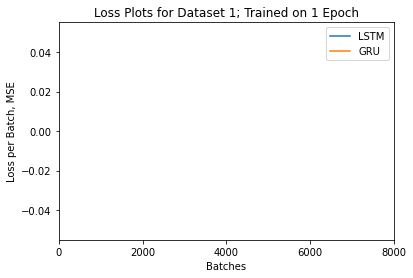

In [77]:
plt.plot(lstm_losses)
plt.plot(gru_losses)

plt.title('Loss Plots for Dataset 1; Trained on 1 Epoch')
plt.xlabel('Batches')
plt.xticks([0,20,40,60,80],[0,2000,4000,6000,8000])
plt.ylabel('Loss per Batch, MSE')
plt.legend(['LSTM', 'GRU'])

In [78]:
# # Save the model weights to continue later
# torch.save(encoder_lstm.state_dict(), '/content/sample_data/encoder2_lstm.pth')
# torch.save(decoder_lstm.state_dict(), '/content/sample_data/decoder2_lstm.pth')

In [79]:
# torch.save(encoder_gru.state_dict(), '/content/sample_data/encoder2_gru.pth')
# torch.save(decoder_gru.state_dict(), '/content/sample_data/decoder2_gru.pth')

Part 4: Using the Model for Evaluation

In [93]:
# Build the idx to word dictionaries to convert predicted indices to words
en_idx2word = {k:i for i, k in en_word2idx.items()}
fr_idx2word = {k:i for i, k in fr_word2idx.items()}

In [94]:
def get_batch(dataloader):
    for batch in dataloader:
        return batch

In [95]:
def evaluate(input_tensor, encoder, decoder):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden(1)
        encoder.eval()
        decoder.eval()

        encoder_output, encoder_hidden = encoder(input_tensor.to(device), encoder_hidden)

        decoder_input =  torch.tensor([fr_word2idx['']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
        try:
            encoder.lstm
            decoder_hidden = (encoder_hidden[0][1::2].contiguous(), encoder_hidden[1][1::2].contiguous())
        except AttributeError:
            decoder_hidden = encoder_hidden[1::2].contiguous()

        output_list = []
        attn_weight_list = np.zeros((seq_length, seq_length))
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)

            decoder_input = output.topk(1)[1].detach()
            output_list.append(output.topk(1)[1])
            word = en_idx2word[output.topk(1)[1].item()]

            attn_weight_list[di] += attn_weights[0,0,:].cpu().numpy()
        return output_list, attn_weight_list

In [96]:
batch = get_batch(dataloader)
input_tensor = batch['french_tensor'][11].unsqueeze_(0)
output_list, attn = evaluate(input_tensor, encoder_lstm, decoder_lstm)
gru_output_list, gru_attn = evaluate(input_tensor, encoder_gru, decoder_gru)

Input Sentence:
 chine est relaxant en automne , et il est chaud en hiver . 

Target Sentence:
 china is relaxing during autumn , and it is hot in winter .

LSTM model output:
 china is relaxing during autumn , and it is warm in winter . 

GRU model output:
 china is relaxing during autumn , and it is warm in winter . 


<ipython-input-97-f6011f4e1b75>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-97-f6011f4e1b75>:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(111)


[Text(0, 0, 'china'),
 Text(0, 0, 'is'),
 Text(0, 0, 'relaxing'),
 Text(0, 0, 'during'),
 Text(0, 0, 'autumn'),
 Text(0, 0, ','),
 Text(0, 0, 'and'),
 Text(0, 0, 'it'),
 Text(0, 0, 'is'),
 Text(0, 0, 'warm'),
 Text(0, 0, 'in'),
 Text(0, 0, 'winter'),
 Text(0, 0, '.')]

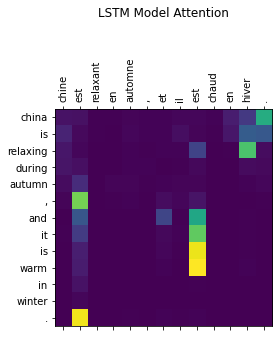

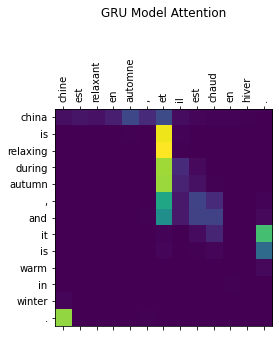

In [97]:
print('Input Sentence:')
input_fr_output = ''
for index in input_tensor[0]:
    word = fr_idx2word[index.item()]
    if word != '':
        input_fr_output += ' ' + word
    else:
        input_fr_output += ' ' + word
        print(input_fr_output)
        break

print('\nTarget Sentence:')
targ_sen_fr = ' ' + batch['english_sentence'][11] + ''
print(targ_sen_fr)
input_len = len(batch['french_sentence'][11].split())

print('\nLSTM model output:')
lstm_fr_output = ''
for index in output_list:
    word = en_idx2word[index.item()]
    if word != '':
        lstm_fr_output += ' ' + word
    else:
        lstm_fr_output += ' ' + word
        print(lstm_fr_output)
        break

fig = plt.figure()
plt.title('LSTM Model Attention\n\n\n\n\n')
ax = fig.add_subplot(111)
ax.matshow(attn[:len(lstm_fr_output.split()), :input_len])
ax.set_xticks(np.arange(0,input_len, step=1))
ax.set_yticks(np.arange(0,len(lstm_fr_output.split())))
ax.set_xticklabels(batch['french_sentence'][11].split(), rotation=90)
ax.set_yticklabels(lstm_fr_output.split()+[''])


gru_fr_output = ''
print('\nGRU model output:')
for index in gru_output_list:
    word = en_idx2word[index.item()]
    if word != '':
        gru_fr_output += ' ' + word
    else:
        gru_fr_output += ' ' + word
        print(gru_fr_output)
        break
        
fig = plt.figure()
plt.title('GRU Model Attention\n\n\n\n\n')
ax2 = fig.add_subplot(111)
ax2.matshow(gru_attn[:len(gru_fr_output.split()), :input_len])
ax2.set_xticks(np.arange(0,input_len, step=1))
ax2.set_yticks(np.arange(0,len(gru_fr_output.split())))
ax2.set_xticklabels(batch['french_sentence'][11].split(), rotation=90)
ax2.set_yticklabels(gru_fr_output.split()+[''])

## FINDING BLEU SCRORE (FRENCH TO ENGLISH):

For LSTM:

In [103]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu

references = [targ_sen_fr.split()]
canidates = [lstm_fr_output.split()]

In [104]:
score = corpus_bleu(references, canidates)
print(score)

1.1409851298103347e-231


FOR GRU:

In [105]:
references = [targ_sen_fr.split()]
canidates = [gru_fr_output.split()]

In [106]:
score = corpus_bleu(references, canidates)
print(score)

1.1409851298103347e-231


# URDU TO ENGLISH:


In [107]:
# Before we get started we will load all the packages we will need

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os.path
import time
import math
import random
import matplotlib.pyplot as plt
import string

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [108]:
with open('/content/drive/MyDrive/machinetranslation/quran-en', "r",encoding="utf8") as f:
    data1 = f.read()
with open('/content/drive/MyDrive/machinetranslation/quran-ur', "r",encoding="utf8") as f:
    data2 = f.read()
    
# The data is just in a text file with each sentence on its own line
english_sentences = data1.split('\n')
urdu_sentences = data2.split('\n')

english_sentences
urdu_sentences

['\ufeffسب تعریفیں اللہ ہی کے لئے ہیں جو تمام جہانوں کی پرورش فرمانے والا ہے ۔',
 'نہایت مہربان بہت رحم فرمانے والا ہے ۔',
 'روزِ جزا کا مالک ہے ۔',
 'اے اللہ ! ہم تیری ہی عبادت کرتے ہیں اور ہم تجھ ہی سے مدد چاہتے ہیں ۔',
 'ہمیں سیدھا راستہ دکھا ۔',
 'ان لوگوں کا راستہ جن پر تو نے انعام فرمایا ۔',
 'ان لوگوں کا نہیں جن پر غضب کیا گیا ہے اور نہ ہی گمراہوں کا ۔',
 'الف لام میم حقیقی معنی اﷲ اور رسول صلی اللہ علیہ وآلہ وسلم ہی بہتر جانتے ہیں ۔',
 'یہ وہ عظیم کتاب ہے جس میں کسی شک کی گنجائش نہیں ، یہ پرہیزگاروں کے لئے ہدایت ہے ۔',
 'جو غیب پر ایمان لاتے اور نماز کو تمام حقوق کے ساتھ قائم کرتے ہیں اور جو کچھ ہم نے انہیں عطا کیا ہے اس میں سے ہماری راہ میں خرچ کرتے ہیں ۔',
 'اور وہ لوگ جو آپ کی طرف نازل کیا گیا اور جو آپ سے پہلے نازل کیا گیا سب پر ایمان لاتے ہیں ، اور وہ آخرت پر بھی کامل یقین رکھتے ہیں ۔',
 'وہی اپنے رب کی طرف سے ہدایت پر ہیں اور وہی حقیقی کامیابی پانے والے ہیں ۔',
 'بیشک جنہوں نے کفر اپنا لیا ہے ان کے لئے برابر ہے خواہ آپ انہیں ڈرائیں یا نہ ڈرائیں ، وہ ایمان نہیں لائیں گے ۔'

In [109]:
print('Number of English sentences:', len(english_sentences), 
      '\nNumber of Urdu sentences:', len(urdu_sentences),'\n')
print('Example/Target pair:\n')
print('  '+english_sentences[2] )
print('  '+urdu_sentences[2] )

Number of English sentences: 6415 
Number of Urdu sentences: 6415 

Example/Target pair:

  Master of the Day of Judgment .
  روزِ جزا کا مالک ہے ۔


In [110]:
english_sentences[2].split()

['Master', 'of', 'the', 'Day', 'of', 'Judgment', '.']

In [115]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length) 

The longest english sentence in our dataset is: 243


In [116]:
max_ur_length = 0
for sentence in urdu_sentences:
    length = len(sentence.split())
    max_ur_length = max(max_ur_length, length)
print("The longest urdu sentence in our dataset is:", max_ur_length)

The longest urdu sentence in our dataset is: 232


In [117]:
max_seq_length = max(max_ur_length, max_en_length) + 1
seq_length = max_seq_length

In [119]:
en_word_count = {}
ur_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in urdu_sentences:
    for word in sentence.split():
        if word in ur_word_count:
            ur_word_count[word] +=1
        else:
            ur_word_count[word] = 1

In [120]:
# Add end of sentence token to word count dict
en_word_count[''] = len(english_sentences)
ur_word_count[''] = len(urdu_sentences)

In [121]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique Urdu words:', len(ur_word_count))

Number of unique English words: 8948
Number of unique Urdu words: 8142


In [122]:
def get_value(items_tuple):
    return items_tuple[1]

# Sort the word counts to see what words or most/least common
sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [123]:
sorted_en_words[:10]

[('(', 12662),
 (')', 12661),
 ('.', 11142),
 ('the', 10838),
 ('and', 7531),
 ('of', 6456),
 ('', 6415),
 (',', 5632),
 ('to', 4559),
 ('you', 4329)]

In [124]:
sorted_ur_words = sorted(ur_word_count.items(), key=get_value, reverse=True)

In [125]:
sorted_ur_words[:10]

[('اور', 10086),
 ('کے', 7212),
 ('۔', 6858),
 ('', 6415),
 ('ہے', 5927),
 ('سے', 5487),
 ('کی', 4971),
 ('میں', 4915),
 ('،', 4465),
 ('اس', 3840)]

So the dataset is pretty small, we may want to get a bigger data set, but we'll see how this one does.

Alternate Dataset Skip this section for now. You can come back and try training on this second dataset later. It is more diverse so it takes longer to train.

Download the Urdu-English dataset from here, Although you could train the model on any of the other language pairs. However, you would need different word embeddings or they would need to be trained from scratch.

In [126]:
with open('/content/drive/MyDrive/machinetranslation/urd.txt', "r",encoding="utf8") as f:
    data1 = f.read()

In [ ]:
pairs = data1.split('\n')
english_sentences = []
Urdu_sentences = []
for i, pair in enumerate(pairs):
    pair_split = pair.split('\t')
    if len(pair_split)!= 2:
        continue
    english = pair_split[0].lower()
    urdu = pair_split[1].lower()
    
    # Remove punctuation and limit sentence length
    max_sent_length = 10
    punctuation_table = english.maketrans({i:None for i in string.punctuation})
    english = english.translate(punctuation_table)
    urdu = urdu.translate(punctuation_table)
    if len(english.split()) > max_sent_length or len(urdu.split()) > max_sent_length:
        continue
       
    english_sentences.append(english)
    urdu_sentences.append(urdu)

In [127]:
print(len(english_sentences) , len(urdu_sentences))
english_sentences[6200].split()

6415 6415


['I', 'swear', 'by', 'this', 'city', '(', 'Makka', ')', '.']

In [128]:
urdu_sentences[6200].split()

['میں', 'اس', 'شہر', 'مکہ', 'کی', 'قَسم', 'کھاتا', 'ہوں', '۔']

In [129]:
print(english_sentences[-100].split())
urdu_sentences[-100].split()

['Their', 'reward', 'is', 'the', 'Gardens', 'of', 'eternal', 'living', 'in', 'the', 'Presence', 'of', 'their', 'Lord', ',', 'with', 'streams', 'flowing', 'under', 'them', '.', 'They', 'shall', 'live', 'in', 'them', 'forever', '.', 'Allah', 'is', 'pleased', 'with', 'them', 'and', 'they', 'are', 'pleased', 'with', 'Him', '.', 'This', '(', 'status', ')', 'is', 'meant', 'for', 'the', 'one', 'who', 'fears', 'his', 'Lord', '.']


['ان',
 'کی',
 'جزا',
 'ان',
 'کے',
 'رب',
 'کے',
 'حضور',
 'دائمی',
 'رہائش',
 'کے',
 'باغات',
 'ہیں',
 'جن',
 'کے',
 'نیچے',
 'سے',
 'نہریں',
 'رواں',
 'ہیں',
 '،',
 'وہ',
 'ان',
 'میں',
 'ہمیشہ',
 'ہمیشہ',
 'رہیں',
 'گے',
 '،',
 'اﷲ',
 'اُن',
 'سے',
 'راضی',
 'ہوگیا',
 'ہے',
 'اور',
 'وہ',
 'لوگ',
 'اس',
 'سے',
 'راضی',
 'ہیں',
 '،',
 'یہ',
 'مقام',
 'اس',
 'شخص',
 'کے',
 'لئے',
 'ہے',
 'جو',
 'اپنے',
 'رب',
 'سے',
 'خائف',
 'رہا',
 '۔']

In [130]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length)  

The longest english sentence in our dataset is: 243


In [131]:
max_ur_length = 0
for sentence in urdu_sentences:
    length = len(sentence.split())
    max_ur_length = max(max_ur_length, length)
print("The longest urdu sentence in our dataset is:", max_ur_length)  

The longest urdu sentence in our dataset is: 232


In [132]:
max_seq_length = max(max_ur_length, max_en_length) + 1
seq_length = max_seq_length

In [133]:
en_word_count = {}
ur_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in urdu_sentences:
    for word in sentence.split():
        if word in ur_word_count:
            ur_word_count[word] +=1
        else:
            ur_word_count[word] = 1

In [134]:
en_word_count[''] = len(english_sentences)
ur_word_count[''] = len(urdu_sentences)

In [135]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique Urdu words:', len(ur_word_count))

Number of unique English words: 8948
Number of unique Urdu words: 8142


In [136]:
ur_word2idx = {k:v+3 for v, k in enumerate(ur_word_count.keys())}
en_word2idx = {k:v+3 for v, k in enumerate(en_word_count.keys())}

In [137]:
ur_word2idx[''] = 0
ur_word2idx[''] = 1
ur_word2idx[''] = 2

en_word2idx[''] = 0
en_word2idx[''] = 1
en_word2idx[''] = 2

In [138]:
len(ur_word2idx)

8142

In [139]:
def get_value(items_tuple):
    return items_tuple[1]

sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [140]:
sorted_en_words[-10:]

[('fibre', 1),
 ('uses', 1),
 ('bunch', 1),
 ('Superior', 1),
 ('harmfulness', 1),
 ('knots', 1),
 ('slinking', 1),
 ('whisperer', 1),
 ('withdrawing', 1),
 ('whispers', 1)]

SKip till now^

Using Word Embeddings

Here we are building an embedding matrix of pretrained word vectors. The word embeddings used here were downloaded from the fastText repository. These embeddings have 300 dimensions. To start we will add a few token embeddings for our specific case. We want a token to signal the start of the sentence, A token for words that we do not have an embedding for, and a token to pad sentences so all the sentences we use have the same length. This will allow us to train the model on batches of sentences that are different lengths, rather than one at a time.

After this step we will have a dictionary and an embedding matrix for each language. The dictionary will map words to an index value in the embedding matrix where its' corresponding embedding vector is stored.

Load Embeddings for the English data

In [141]:
# The data file containing the embeddings is very large so once we have the embeddings we want
# we will save them as a numpy array. This way we can load this much faster then having to re read from
# the large embedding file
if os.path.exists('/content/drive/MyDrive/machinetranslation/en_words.npy') and os.path.exists('/content/drive/MyDrive/machinetranslation/en_vectors.npy'):
    en_words = np.load('/content/drive/MyDrive/machinetranslation/en_words.npy')
    en_vectors = np.load('/content/drive/MyDrive/machinetranslation/en_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    en_words = ['', # Padding Token
                '', # Start of sentence token
                ''# Unknown word token
               ]

    en_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    en_vectors[0] *= 0 # make the padding vector zeros

    with open('wiki.en.vec', "r",encoding="utf8") as f:
        f.readline()
        for _ in range(100000):
            en_vecs = f.readline()
            word = en_vecs.split()[0]
            vector = np.float32(en_vecs.split()[1:])

            # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in en_words:
                en_words.append(word)
                en_vectors.append(vector)
        print(word, vector[:10]) # Last word embedding read from the file
        en_words = np.array(en_words)
        en_vectors = np.array(en_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('/content/drive/MyDrive/machinetranslation/en_words.npy', en_words)
    np.save('/content/drive/MyDrive/machinetranslation/en_vectors.npy', en_vectors)

Embeddings load from .npy file


In [142]:
en_word2idx = {word:index for index, word in enumerate(en_words)}

In [143]:
hemophilia_idx = en_word2idx['superior']
print('index for word superior:', hemophilia_idx, 
      '\nvector for word superior:\n',en_vectors[hemophilia_idx][:10])

index for word superior: 4388 
vector for word superior:
 [-2.32999995e-02  1.71000008e-02 -9.99999975e-05  4.41000015e-02
 -4.83999997e-02 -3.97999994e-02  4.65999991e-02 -1.18000004e-02
 -5.99999987e-02  3.97000015e-02]


The word embedding for hemophilia matches the one read from the file, so it looks like everything worked properly.

Load Embeddings for the Urdu data

In [144]:
if os.path.exists('/content/drive/MyDrive/machinetranslation/ur_words.npy') and os.path.exists('/content/drive/MyDrive/machinetranslation/ur_vectors.npy'):
    ur_words = np.load('/content/drive/MyDrive/machinetranslation/ur_words.npy')
    ur_vectors = np.load('/content/drive/MyDrive/machinetranslation/ur_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    ur_words = ['',
                '',
                '']

    ur_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    ur_vectors[0] = np.zeros(300) # make the padding vector zeros

    with open('wiki.ur.vec', "r",encoding="utf8") as f:
        f.readline()
        for _ in range(100000):
            ur_vecs = f.readline()
            word = ur_vecs.split()[0]
            try:
                vector = np.float32(ur_vecs.split()[1:])
            except ValueError:
                continue

             # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in ur_words:
                ur_words.append(word)
                ur_vectors.append(vector)
        print(word, vector[:10])
        ur_words = np.array(ur_words)
        ur_vectors = np.array(ur_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('/content/drive/MyDrive/machinetranslation/ur_words.npy', ur_words)
    np.save('/content/drive/MyDrive/machinetranslation/ur_vectors.npy', ur_vectors)

Embeddings load from .npy file


In [145]:
ur_word2idx = {word:index for index, word in enumerate(ur_words)}

In [146]:
chabeuil_idx = ur_word2idx['رب']
print('index for word رب:', chabeuil_idx, 
      '\nvector for word رب:\n',ur_vectors[chabeuil_idx][:10])

index for word رب: 1137 
vector for word رب:
 [-0.1596     -0.1416     -0.1035     -0.36809999  0.0841     -0.0548
  0.1609     -0.24240001 -0.0877     -0.0433    ]


In [148]:
ur_word2idx["رب"]

1137

The word embedding for chabeuil matches as well so everything worked correctly for the french vocab.

Ok, so we have all the pieces needed to take words and convert them into word embeddings. These word embeddings already have a lot of useful information about how words relate since we loaded the pre-trained word embeddings. Now we can build the translation model with the embedding matrices built in.

Setting up PyTorch Dataset and Dataloader Rather than organizing all the data from a file and storing it in a list or some other data structure, PyTorch allows us to create a dataset object. To get an example from a dataset we just index the dataset object like we would a list. However, all our processing can be contained in the objects initialization or indexing process.

This will also make training easier when we want to iterate through batches.

In [149]:
class Urdu2EnglishDataset(Dataset):
    '''
        Urdu and associated English sentences.
    '''
    
    def __init__(self, ur_sentences, en_sentences, ur_word2idx, en_word2idx, seq_length):
        self.ur_sentences = ur_sentences
        self.en_sentences = en_sentences
        self.ur_word2idx = ur_word2idx
        self.en_word2idx = en_word2idx
        self.seq_length = seq_length
        self.unk_en = set()
        self.unk_ur = set()
    
    def __len__(self):
        return len(urdu_sentences)
    
    def __getitem__(self, idx):
        '''
            Returns a pair of tensors containing word indices
            for the specified sentence pair in the dataset.
        '''
        
        # init torch tensors, note that 0 is the padding index
        urdu_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        english_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        
        # Get sentence pair
        urdu_sentence = self.ur_sentences[idx].split()
        english_sentence = self.en_sentences[idx].split()
        
        # Add  tags
        urdu_sentence.append('')
        english_sentence.append('')
        
        # Load word indices
        for i, word in enumerate(urdu_sentence):
            if word in ur_word2idx and ur_word_count[word] > 5:
                urdu_tensor[i] = ur_word2idx[word]
            else:
                urdu_tensor[i] = ur_word2idx['']
                self.unk_ur.add(word)
        
        for i, word in enumerate(english_sentence):
            if word in en_word2idx and en_word_count[word] > 5:
                english_tensor[i] = en_word2idx[word]
            else:
                english_tensor[i] = en_word2idx['']
                self.unk_en.add(word)
            
        sample = {'urdu_tensor': urdu_tensor, 'urdu_sentence': self.ur_sentences[idx],
                  'english_tensor': english_tensor, 'english_sentence': self.en_sentences[idx]}
        return sample

In [150]:
urdu_english_dataset = Urdu2EnglishDataset(urdu_sentences,
                                               english_sentences,
                                               ur_word2idx,
                                               en_word2idx,
                                               seq_length = seq_length)

In [151]:
test_sample = urdu_english_dataset[-10] # get 10th to last item in dataset

In [152]:
print('Input example:')
print('Sentence:', test_sample['urdu_sentence'])
print('Tensor:', test_sample['urdu_tensor'])

print('\nTarget example:')
print('Sentence:', test_sample['english_sentence'])
print('Tensor:', test_sample['english_tensor'])

Input example:
Sentence: اور بالخصوص اندھیری رات کے شر سے جب اس کی ظلمت چھا جائے ۔
Tensor: tensor([  11,    2,    2,  586,    6, 3832,   12,   80,   17,    8,    2, 7197,
          94,    4,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    

In [154]:
# Check that both tensors end with the end of sentence token
print(ur_word2idx[''])
en_word2idx['']

2


2

In [155]:
# Build dataloader to check how the batching works
dataloader = DataLoader(urdu_english_dataset, batch_size=2,
                        shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [156]:
# Prints out 10 batches from the dataloader
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['urdu_tensor'].shape,
          sample_batched['english_tensor'].shape)
    if i_batch == 3:
        break

0 torch.Size([2, 244]) torch.Size([2, 244])
1 torch.Size([2, 244]) torch.Size([2, 244])
2 torch.Size([2, 244]) torch.Size([2, 244])
3 torch.Size([2, 244]) torch.Size([2, 244])


In [157]:
for i in dataloader:
    batch = i
    break

for i in range(2):
    print('Urdu Sentence:', batch['urdu_sentence'][i])
    print('English Sentence:', batch['english_sentence'][i],'\n')

Urdu Sentence: بیشک جن لوگوں کے لئے پہلے سے ہی ہماری طرف سے بھلائی مقرر ہو چکی ہے وہ اس جہنم سے دور رکھے جائیں گے ۔
English Sentence: Surely those for whom good has already been decreed from Us will be kept away from ( Hell ) . 

Urdu Sentence: اور یہ کہ مرنے کے بعد دوبارہ زندہ کرنا بھی اسی پر ہے ۔
English Sentence: And that it is upon Him alone to raise up alive ( also after death ) . 



Part 2: Building the Model
Bi-Directional Encoder

In [158]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiLSTM, self).__init__()
        
        # Model Parameters
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings)) #Load the pretrained embeddings
        self.embedding.weight.requires_grad = False #Freeze embedding layer
        
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # This improves training and prevents exploding gradients
        # PyTorch LSTM has the 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.lstm(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        cell_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                 batch_size,
                                 self.hidden_size, 
                                 device=device)
        
        return (hidden_state, cell_state)

In [159]:
class EncoderBiGRU(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiGRU, self).__init__()
        
        # Model parameters
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.gru.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.gru(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        return hidden_state

Testing the Encoder

In [160]:
# Test the encoder on a sample input, input tensor has dimensions (batch_size, seq_length)
# all the variable have test_ in front of them so they don't reassign variables needed later on with the real models

test_batch_size = 1
test_seq_length = 3
test_hidden_size = 5
test_encoder = EncoderBiLSTM(test_hidden_size, ur_vectors).to(device)
test_hidden = test_encoder.initHidden(test_batch_size)

# Create an input tensor of random indices
test_inputs = torch.randint(0, 50, (test_batch_size, test_seq_length), dtype=torch.long, device=device)

test_encoder_output, test_encoder_hidden = test_encoder.forward(test_inputs, test_hidden)

print("The final output of the BiLSTM Encoder on our test input is: \n\n", test_encoder_output.shape)

print('\n\nEncoder output tensor: \n\n', test_encoder_output)

The final output of the BiLSTM Encoder on our test input is: 

 torch.Size([1, 3, 10])


Encoder output tensor: 

 tensor([[[-0.0877,  0.1706, -0.0435,  0.0832,  0.0475, -0.1715,  0.2395,
          -0.1193, -0.2290,  0.0324],
         [-0.1350,  0.3082, -0.0784,  0.1531,  0.0710, -0.1691,  0.1905,
          -0.0963, -0.2325,  0.0102],
         [-0.1378,  0.4350, -0.0847,  0.2217,  0.0978, -0.1546,  0.1113,
          -0.0619, -0.1908, -0.0056]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)


In [162]:
test_encoder_hidden# Tuple where first item is the hidden states, second item is the cell states.

# The lstm has 2 layers, each layer has a forward and backward pass giving 4

(tensor([[[ 0.2635,  0.0930,  0.0028, -0.1320,  0.1404]],
 
         [[ 0.4149, -0.1132, -0.1725, -0.0339, -0.0205]],
 
         [[-0.1378,  0.4350, -0.0847,  0.2217,  0.0978]],
 
         [[-0.1715,  0.2395, -0.1193, -0.2290,  0.0324]]], device='cuda:0',
        grad_fn=<CudnnRnnBackward0>),
 tensor([[[ 0.5235,  0.2129,  0.0052, -0.4373,  0.2053]],
 
         [[ 0.9865, -0.2116, -0.3602, -0.0613, -0.0365]],
 
         [[-0.3910,  0.8565, -0.1941,  0.5295,  0.1568]],
 
         [[-0.5222,  0.5773, -0.3028, -0.4086,  0.0641]]], device='cuda:0',
        grad_fn=<CudnnRnnBackward0>))

In [163]:
test_encoder_hidden[0][::2] # Hidden states from forward pass for both lstm layers.

tensor([[[ 0.2635,  0.0930,  0.0028, -0.1320,  0.1404]],

        [[-0.1378,  0.4350, -0.0847,  0.2217,  0.0978]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [164]:
test_encoder_gru = EncoderBiGRU(test_hidden_size, ur_vectors).to(device)
test_hidden = test_encoder_gru.initHidden(test_batch_size)
o,h = test_encoder_gru(test_inputs, test_hidden)

In [165]:
o

tensor([[[ 0.1891, -0.0096,  0.5434,  0.0281, -0.1182, -0.0436,  0.1947,
          -0.1520,  0.0785, -0.3193],
         [ 0.3970,  0.1004,  0.7138,  0.0642, -0.2221, -0.0166,  0.1470,
          -0.1608,  0.0719, -0.1618],
         [ 0.5237,  0.2594,  0.7914,  0.0924, -0.2669, -0.0043,  0.1331,
          -0.0239,  0.0167, -0.0367]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)

In [166]:
print(h)
h[1::2]

tensor([[[-0.0712,  0.3762,  0.3031, -0.2914,  0.1516]],

        [[-0.3197, -0.3107, -0.0659,  0.6209, -0.2867]],

        [[ 0.5237,  0.2594,  0.7914,  0.0924, -0.2669]],

        [[-0.0436,  0.1947, -0.1520,  0.0785, -0.3193]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)


tensor([[[-0.3197, -0.3107, -0.0659,  0.6209, -0.2867]],

        [[-0.0436,  0.1947, -0.1520,  0.0785, -0.3193]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Attention
Let's take a moment test how attention is being modeled. Weighted sum of sequence items from encoder output.

In [167]:
# Initialize attention weights to one, note the dimensions
attn_weights = torch.ones((test_batch_size, test_seq_length),device=device)

# Set all weights except the weights associated with the first sequence item equal to zero
# This would represent full attention on the first word in the sequence
attn_weights[:, 1:] = 0

attn_weights.unsqueeze_(1) # Add dimension for batch matrix multiplication

# BMM(Batch Matrix Multiply) muliplies the [1 x seq_length] matrix by the [seq_length x hidden_size] matrix for
# each batch. This produces a single vector(for each batch) of length(encoder_hidden_size) that is the weighted
# sum of the encoder hidden vectors for each item in the sequence.
attn_applied = torch.bmm(attn_weights, test_encoder_output)
attn_applied.squeeze_() # Remove extra dimension

print('Attention weights:\n', attn_weights)
print('\nFirst sequence item in Encoder output: \n', test_encoder_output[:,0,:])
print('\nEncoder Output after attention is applied: \n', attn_applied)
print('\n', attn_applied.shape)

Attention weights:
 tensor([[[1., 0., 0.]]], device='cuda:0')

First sequence item in Encoder output: 
 tensor([[-0.0877,  0.1706, -0.0435,  0.0832,  0.0475, -0.1715,  0.2395, -0.1193,
         -0.2290,  0.0324]], device='cuda:0', grad_fn=<SliceBackward0>)

Encoder Output after attention is applied: 
 tensor([-0.0877,  0.1706, -0.0435,  0.0832,  0.0475, -0.1715,  0.2395, -0.1193,
        -0.2290,  0.0324], device='cuda:0', grad_fn=<SqueezeBackward2>)

 torch.Size([10])


Decoder with Attention

In [168]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length):
        super(AttnDecoderLSTM, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # LSTM parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.1 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = 2*decoder_hidden_size
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear((self.decoder_hidden_size + self.embedding_dim), self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # LSTM for Decoder
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # PyTorch LSTM has 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[0][1], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare LSTM input tensor
        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        lstm_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        lstm_input = lstm_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.lstm(lstm_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        
        return output, hidden, attn_weights

In [169]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length):
        super(AttnDecoderGRU, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # GRU parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.1 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = 2*decoder_hidden_size
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear(self.decoder_hidden_size + self.embedding_dim, self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # gru for Decoder
        self.gru = nn.GRU(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.gru.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.gru.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[0], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare GRU input tensor

        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        gru_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        gru_input = gru_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.gru(gru_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        return output, hidden, attn_weights

Testing the Decoder

In [170]:
# Test the decoder on sample inputs to check that the dimensions of everything is correct
test_decoder_hidden_size = 5

test_decoder = AttnDecoderLSTM(test_decoder_hidden_size, en_vectors, test_seq_length).to(device)

In [171]:
input_idx = torch.tensor([ur_word2idx['']]*test_batch_size, dtype=torch.long, device=device)

In [172]:
input_idx.shape

torch.Size([1])

In [173]:
input_idx = input_idx.unsqueeze_(0)
test_decoder_hidden = (test_encoder_hidden[0][1::2].contiguous(), test_encoder_hidden[1][1::2].contiguous())

In [174]:
input_idx.shape

torch.Size([1, 1])

In [175]:
output, hidden, attention = test_decoder.forward(input_idx, test_decoder_hidden, test_encoder_output)
print(output.shape)

torch.Size([1, 100003])


In [176]:
test_decoder_hidden[0].shape

torch.Size([2, 1, 5])

Part 3: Training the Model
Training Function

In [177]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion):
    
    # Initialize encoder hidden state
    encoder_hidden = encoder.initHidden(input_tensor.shape[0])
    
    # clear the gradients in the optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # run forward pass through encoder on entire sequence
    encoder_output, encoder_hidden = encoder.forward(input_tensor, encoder_hidden)
    
    # Initialize decoder input(Start of Sentence tag) and hidden state from encoder
    decoder_input =  torch.tensor([en_word2idx['']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
    
    # Use correct initial hidden state dimensions depending on type of RNN
    try:
        encoder.lstm
        decoder_hidden = (encoder_hidden[0][1::2].contiguous(), encoder_hidden[1][1::2].contiguous())
    except AttributeError:
        decoder_hidden = encoder_hidden[1::2].contiguous()
    
    # Initialize loss
    loss = 0
    
    # Implement teacher forcing
    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        # Step through target output sequence
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)
            
            # Feed target as input to next item in the sequence
            decoder_input = target_tensor[di].unsqueeze(0)
            loss += criterion(output, target_tensor[di])
    else:
        # Step through target output sequence
        for di in range(seq_length):
            
            # Forward pass through decoder
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)
            
            # Feed output as input to next item in the sequence
            decoder_input = output.topk(1)[1].view(1,-1).detach()
            
            # Calculate loss
            loss += criterion(output, target_tensor[di])
    
    # Compute the gradients
    loss.backward()
    
    # Clip the gradients
    nn.utils.clip_grad_norm_(encoder.parameters(), 25)
    nn.utils.clip_grad_norm_(decoder.parameters(), 25)
    
    # Update the weights
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()

Training Loop

In [179]:
def trainIters(encoder, decoder, dataloader, epochs, print_every_n_batches=100, learning_rate=0.01):
    
    # keep track of losses
    plot_losses = []

    # Initialize Encoder Optimizer
    encoder_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
    encoder_optimizer = optim.Adam(encoder_parameters, lr=learning_rate)
    
    # Initialize Decoder Optimizer
    decoder_parameters = filter(lambda p: p.requires_grad, decoder.parameters())
    decoder_optimizer = optim.Adam(decoder_parameters, lr=learning_rate)

    # Specify loss function, ignore the  token index so it does not contribute to loss.
    criterion = nn.NLLLoss(ignore_index=0)
    
    # Cycle through epochs
    for epoch in range(epochs):
        loss_avg = 0
        print(f'Epoch {epoch + 1}/{epochs}')
        # Cycle through batches
        for i, batch in enumerate(dataloader):
            
            input_tensor = batch['urdu_tensor'].to(device)
            target_tensor = batch['english_tensor'].transpose(1,0).to(device)
            

            loss = train(input_tensor, target_tensor, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, criterion)
            
            loss_avg += loss
            if i % print_every_n_batches == 0 and i != 0:
                loss_avg /= print_every_n_batches
                print(f'After {i} batches, average loss/{print_every_n_batches} batches: {loss_avg}')
                plot_losses.append(loss)
                loss_avg = 0
    return plot_losses

Training the Model

In [180]:
# Set hyperparameters and construct dataloader
hidden_size = 256
batch_size = 16
dataloader = DataLoader(urdu_english_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4) 

In [181]:
# Construct encoder and decoder instances
encoder_lstm = EncoderBiLSTM(hidden_size, ur_vectors).to(device)
decoder_lstm = AttnDecoderLSTM(hidden_size, en_vectors, seq_length).to(device)

encoder_gru = EncoderBiGRU(hidden_size, ur_vectors).to(device)
decoder_gru = AttnDecoderGRU(hidden_size, en_vectors, seq_length).to(device)

In [182]:
# from_scratch = True # Set to False if you have saved weights and want to load them

# if not from_scratch:
#     # Load weights from earlier model
#     encoder_lstm_state_dict = torch.load('/content/sample_data/encoder1_lstm.pth')
#     decoder_lstm_state_dict = torch.load('/content/sample_data/decoder1_lstm.pth')

#     encoder_lstm.load_state_dict(encoder_lstm_state_dict)
#     decoder_lstm.load_state_dict(decoder_lstm_state_dict)
    
#         # Load weights from earlier model
#     encoder_gru_state_dict = torch.load('/content/sample_data/encoder1_gru.pth')
#     decoder_gru_state_dict = torch.load('/content/sample_data/decoder1_gru.pth')

#     encoder_gru.load_state_dict(encoder_gru_state_dict)
#     decoder_gru.load_state_dict(decoder_gru_state_dict)
# else:
#     print('Training model from scratch.')

In [183]:

    # Load weights from earlier model
    encoder_lstm_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/encoder2_ur_lstm.pth')
    decoder_lstm_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/decoder2_ur_lstm.pth')

    encoder_lstm.load_state_dict(encoder_lstm_state_dict)
    decoder_lstm.load_state_dict(decoder_lstm_state_dict)
    
        # Load weights from earlier model
    encoder_gru_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/encoder2_ur_gru.pth')
    decoder_gru_state_dict = torch.load('/content/drive/MyDrive/machinetranslation/decoder2_ur_gru.pth')

    encoder_gru.load_state_dict(encoder_gru_state_dict)
    decoder_gru.load_state_dict(decoder_gru_state_dict)


<All keys matched successfully>

In [ ]:
# For dataset 1, models were trained for 3 epochs
# For dataset 2, models were trained for 50 epochs

learning_rate = 0.0001
encoder_lstm.train() # Set model to training mode
decoder_lstm.train() # Set model to training mode

lstm_losses_cont = trainIters(encoder_lstm, decoder_lstm, dataloader, epochs=9, learning_rate = learning_rate)


# For dataset 1, models were trained for 3 epochs
# For dataset 2, models were trained for 50 epochs
print('Training GRU based network.')
learning_rate = 0.0001
encoder_gru.train() # Set model to training mode
decoder_gru.train() # Set model to training mode

gru_losses = trainIters(encoder_gru, decoder_gru, dataloader, epochs=9, learning_rate = learning_rate)

Epoch 1/9
After 100 batches, average loss/100 batches: nan
After 200 batches, average loss/100 batches: nan
After 300 batches, average loss/100 batches: nan
After 400 batches, average loss/100 batches: nan
Epoch 2/9
After 100 batches, average loss/100 batches: nan
After 200 batches, average loss/100 batches: nan
After 300 batches, average loss/100 batches: nan
After 400 batches, average loss/100 batches: nan
Epoch 3/9
After 100 batches, average loss/100 batches: nan
After 200 batches, average loss/100 batches: nan
After 300 batches, average loss/100 batches: nan
After 400 batches, average loss/100 batches: nan
Epoch 4/9
After 100 batches, average loss/100 batches: nan
After 200 batches, average loss/100 batches: nan
After 300 batches, average loss/100 batches: nan
After 400 batches, average loss/100 batches: nan
Epoch 5/9
After 100 batches, average loss/100 batches: nan
After 200 batches, average loss/100 batches: nan
After 300 batches, average loss/100 batches: nan
After 400 batches, 

In [ ]:
# np.save('/content/sample_data/lstm2_ur_losses.npy', lstm_losses_cont)

In [ ]:
# np.save('/content/sample_data/gru2_ur_losses.npy', gru_losses)

In [184]:
lstm_losses = np.load('/content/drive/MyDrive/machinetranslation/lstm2_ur_losses.npy')
gru_losses = np.load('/content/drive/MyDrive/machinetranslation/gru2_ur_losses.npy')

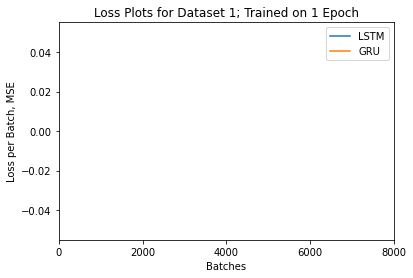

In [185]:
plt.plot(lstm_losses)
plt.plot(gru_losses)

plt.title('Loss Plots for Dataset 1; Trained on 1 Epoch')
plt.xlabel('Batches')
plt.xticks([0,20,40,60,80],[0,2000,4000,6000,8000])
plt.ylabel('Loss per Batch, MSE')
plt.legend(['LSTM', 'GRU'])

In [ ]:
# # Save the model weights to continue later
# torch.save(encoder_lstm.state_dict(), '/content/sample_data/encoder2_ur_lstm.pth')
# torch.save(decoder_lstm.state_dict(), '/content/sample_data/decoder2_ur_lstm.pth')

In [ ]:
# torch.save(encoder_gru.state_dict(), '/content/sample_data/encoder2_ur_gru.pth')
# torch.save(decoder_gru.state_dict(), '/content/sample_data/decoder2_ur_gru.pth')

Part 4: Using the Model for Evaluatio

In [186]:
# Build the idx to word dictionaries to convert predicted indices to words
en_idx2word = {k:i for i, k in en_word2idx.items()}
ur_idx2word = {k:i for i, k in ur_word2idx.items()}

In [187]:
def get_batch(dataloader):
    for batch in dataloader:
        return batch

In [188]:
def evaluate(input_tensor, encoder, decoder):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden(1)
        encoder.eval()
        decoder.eval()

        encoder_output, encoder_hidden = encoder(input_tensor.to(device), encoder_hidden)

        decoder_input =  torch.tensor([ur_word2idx['']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
        try:
            encoder.lstm
            decoder_hidden = (encoder_hidden[0][1::2].contiguous(), encoder_hidden[1][1::2].contiguous())
        except AttributeError:
            decoder_hidden = encoder_hidden[1::2].contiguous()

        output_list = []
        attn_weight_list = np.zeros((seq_length, seq_length))
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder(decoder_input,
                                                           decoder_hidden,
                                                           encoder_output)

            decoder_input = output.topk(1)[1].detach()
            output_list.append(output.topk(1)[1])
            word = en_idx2word[output.topk(1)[1].item()]

            attn_weight_list[di] += attn_weights[0,0,:].cpu().numpy()
        return output_list, attn_weight_list

In [189]:
batch = get_batch(dataloader)
input_tensor = batch['urdu_tensor'][11].unsqueeze_(0)
output_list, attn = evaluate(input_tensor, encoder_lstm, decoder_lstm)
gru_output_list, gru_attn = evaluate(input_tensor, encoder_gru, decoder_gru)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Input Sentence:
 اور بیشک تمہارے لئے مویشیوں میں بھی مقامِ غور ہے ، ہم ان کے جسموں کے اندر کی اس چیز سے جو 

Target Sentence:
 And indeed in the cattle ( too ) there is a point for you to ponder . We provide you with pure milk to drink brought forth from that substance of their bellies ( which is produced by ) compounding ( certain ) intestinal contents and blood and which freshens up those who drink it .

LSTM model output:
 And We ( ( the the the the the 

GRU model output:
 And ( the the the the the the the the the the the the the the the the 


<ipython-input-190-75e23829bdb4>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-190-75e23829bdb4>:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(111)


[Text(0, 0, 'And'),
 Text(0, 0, '('),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the'),
 Text(0, 0, 'the')]

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1748 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1748 missing from current font.
  font.set_text(s, 0,

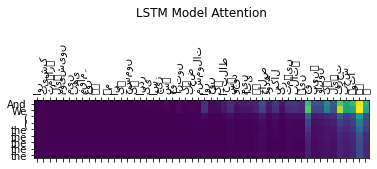

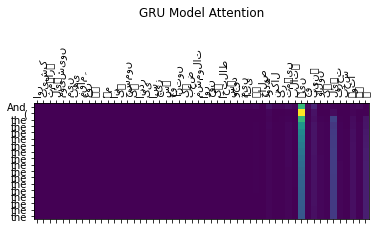

In [190]:
print('Input Sentence:')
input_ur_output = ''
for index in input_tensor[0]:
    word = ur_idx2word[index.item()]
    if word != '':
        input_ur_output += ' ' + word
    else:
        input_ur_output += ' ' + word
        print(input_ur_output)
        break

print('\nTarget Sentence:')
targ_sen_ur = ' ' + batch['english_sentence'][11] + ''
print(targ_sen_ur)
input_len = len(batch['urdu_sentence'][11].split())

print('\nLSTM model output:')
lstm_ur_output = ''
for index in output_list:
    word = en_idx2word[index.item()]
    if word != '':
        lstm_ur_output += ' ' + word
    else:
        lstm_ur_output += ' ' + word
        print(lstm_ur_output)
        break

fig = plt.figure()
plt.title('LSTM Model Attention\n\n\n\n\n')
ax = fig.add_subplot(111)
ax.matshow(attn[:len(lstm_ur_output.split()), :input_len])
ax.set_xticks(np.arange(0,input_len, step=1))
ax.set_yticks(np.arange(0,len(lstm_ur_output.split())))
ax.set_xticklabels(batch['urdu_sentence'][11].split(), rotation=90)
ax.set_yticklabels(lstm_ur_output.split()+[''])


gru_ur_output = ''
print('\nGRU model output:')
for index in gru_output_list:
    word = en_idx2word[index.item()]
    if word != '':
        gru_ur_output += ' ' + word
    else:
        gru_ur_output += ' ' + word
        print(gru_ur_output)
        break
        
fig = plt.figure()
plt.title('GRU Model Attention\n\n\n\n\n')
ax2 = fig.add_subplot(111)
ax2.matshow(gru_attn[:len(gru_ur_output.split()), :input_len])
ax2.set_xticks(np.arange(0,input_len, step=1))
ax2.set_yticks(np.arange(0,len(gru_ur_output.split())))
ax2.set_xticklabels(batch['urdu_sentence'][11].split(), rotation=90)
ax2.set_yticklabels(gru_ur_output.split()+[''])

## FINDING BLEU SCORE OF URDU TO ENGLISH:

FOR LSTM:

In [192]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu

references = [targ_sen_ur.split()]
canidates = [lstm_ur_output.split()]

In [193]:
score = corpus_bleu(references, canidates)
print(score)

1.0518351895246305e-231


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

FOR GRU:

In [196]:
references = [targ_sen_ur.split()]
canidates = [gru_ur_output.split()]

In [197]:
score = corpus_bleu(references, canidates)
print(score)

8.844844403089351e-232
